# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 557957 X 14900 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../../../../data-pre-processing/2csv/cenario2_8M2021_tweets_en.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 557957 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("english.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 179 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 15165 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.3488
K=10: Coherence=0.3006
K=15: Coherence=0.3003
K=20: Coherence=0.2899


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

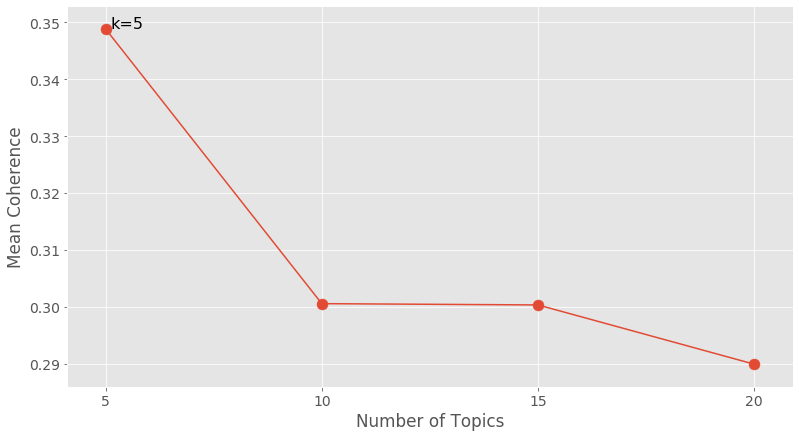

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.3035
K=10: Coherence=0.2823
K=15: Coherence=0.2682
K=20: Coherence=0.2613


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


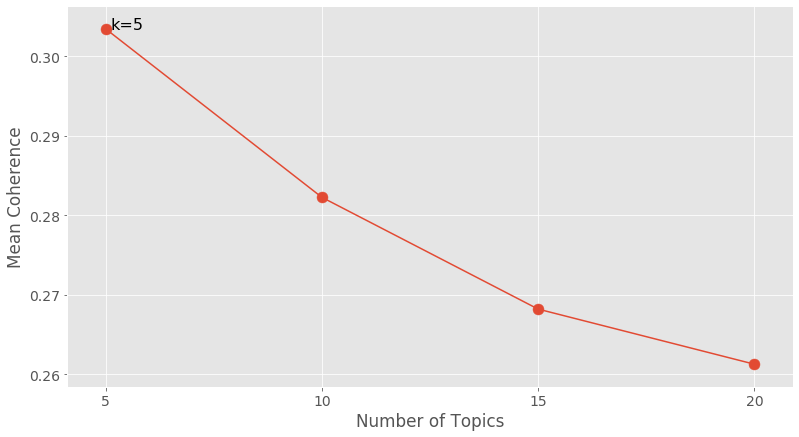

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2912
K=10: Coherence=0.2608
K=15: Coherence=0.2516
K=20: Coherence=0.2466


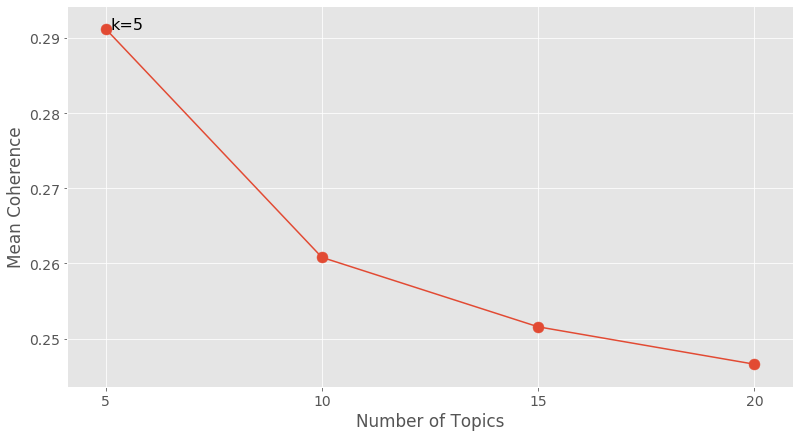

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [21]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2739
K=10: Coherence=0.2436
K=15: Coherence=0.2401
K=20: Coherence=0.2359


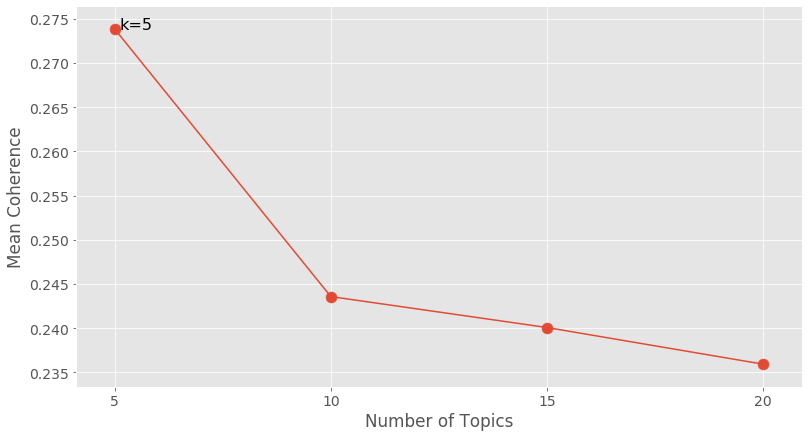

In [22]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, celebrating
Topic 02: women, amp, today, celebrate, amazing
Topic 03: happy, beautiful, ladies, strong, love
Topic 04: woman, every, love, god, strong
Topic 05: world, challenge, gender, choose, around


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, celebrating, march, men, wishes, celebration, via
Topic 02: women, amp, today, celebrate, amazing, thank, work, celebrating, many, support
Topic 03: happy, beautiful, ladies, strong, love, amazing, wonderful, iwd, everyone, wishing
Topic 04: woman, every, love, god, strong, day, one, life, beautiful, man
Topic 05: world, challenge, gender, choose, around, let, change, bias, inequality, celebrate


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, celebrating, march, men, wishes, celebration, via, celebrate, special, celebrates, celebrated, womens
Topic 02: women, amp, today, celebrate, amazing, thank, work, celebrating, many, support, life, great, proud, female, incredible
Topic 03: happy, beautiful, ladies, strong, love, amazing, wonderful, iwd, everyone, wishing, women, keep, womens, may, queens
Topic 04: woman, every, love, god, strong, day, one, life, beautiful, man, know, single, like, respect, proud
Topic 05: world, challenge, gender, choose, around, let, change, bias, inequality, celebrate, achievements, comes, equal, equality, inclusive


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, celebrating, march, men, wishes, celebration, via, celebrate, special, celebrates, celebrated, womens, 8th, trans, wish, occasion, good
Topic 02: women, amp, today, celebrate, amazing, thank, work, celebrating, many, support, life, great, proud, female, incredible, team, like, make, strong, everyday
Topic 03: happy, beautiful, ladies, strong, love, amazing, wonderful, iwd, everyone, wishing, women, keep, womens, may, queens, wish, life, world, lovely, incredible
Topic 04: woman, every, love, god, strong, day, one, life, beautiful, man, know, single, like, respect, proud, mother, always, first, best, another
Topic 05: world, challenge, gender, choose, around, let, change, bias, inequality, celebrate, achievements, comes, equal, equality, inclusive, theme, call, alert, challenged, help


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, march
Topic 02: women, amazing, work, celebrating, life
Topic 03: happy, ladies, iwd, everyone, wishing
Topic 04: woman, every, god, one, life
Topic 05: world, challenge, gender, choose, around
Topic 06: amp, gender, female, girls, support
Topic 07: today, celebrate, every, achievements, everyday
Topic 08: love, much, respect, ladies, life
Topic 09: thank, much, great, wonderful, work
Topic 10: strong, beautiful, may, know, raise


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, march, womens, celebration, via, celebrating, wishes
Topic 02: women, amazing, work, celebrating, life, many, proud, great, incredible, support
Topic 03: happy, ladies, iwd, everyone, wishing, wonderful, beautiful, wish, womens, wishes
Topic 04: woman, every, god, one, life, day, man, like, single, proud
Topic 05: world, challenge, gender, choose, around, change, let, bias, inequality, comes
Topic 06: amp, gender, female, girls, support, join, equality, thanks, work, leaders
Topic 07: today, celebrate, every, achievements, everyday, let, celebrating, day, join, female
Topic 08: love, much, respect, ladies, life, always, see, sending, beautiful, show
Topic 09: thank, much, great, wonderful, work, inspiring, support, everything, like, sharing
Topic 10: strong, beautiful, may, know, raise, powerful, women, ladies, independent, brave


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, march, womens, celebration, via, celebrating, wishes, special, celebrated, 8th, celebrates, good
Topic 02: women, amazing, work, celebrating, life, many, proud, great, incredible, support, team, make, men, like, one
Topic 03: happy, ladies, iwd, everyone, wishing, wonderful, beautiful, wish, womens, wishes, queens, lovely, keep, world, friends
Topic 04: woman, every, god, one, life, day, man, like, single, proud, first, mother, another, best, respect
Topic 05: world, challenge, gender, choose, around, change, let, bias, inequality, comes, equal, inclusive, theme, alert, challenged
Topic 06: amp, gender, female, girls, support, join, equality, thanks, work, leaders, new, share, leadership, health, event
Topic 07: today, celebrate, every, achievements, everyday, let, celebrating, day, join, female, political, social, cultural, economic, equality
Topic 08: love, much, respect, ladies, life, always, see, sending, beautiful, show, thanks, apprecia

In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, every, march, womens, celebration, via, celebrating, wishes, special, celebrated, 8th, celebrates, good, men, occasion, year, wish, cultural
Topic 02: women, amazing, work, celebrating, life, many, proud, great, incredible, support, team, make, men, like, one, working, inspiring, girls, rights, inspire
Topic 03: happy, ladies, iwd, everyone, wishing, wonderful, beautiful, wish, womens, wishes, queens, lovely, keep, world, friends, incredible, female, team, favorite, birthday
Topic 04: woman, every, god, one, life, day, man, like, single, proud, first, mother, another, best, respect, magic, without, power, inspires, know
Topic 05: world, challenge, gender, choose, around, change, let, bias, inequality, comes, equal, inclusive, theme, alert, challenged, equality, call, achievements, help, create
Topic 06: amp, gender, female, girls, support, join, equality, thanks, work, leaders, new, share, leadership, health, event, read, time, live, future, many
To

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens
Topic 02: women, life, incredible, men, rights
Topic 03: happy, ladies, iwd, everyone, wishing
Topic 04: woman, god, life, man, first
Topic 05: world, around, better, make, place
Topic 06: amp, girls, join, support, leadership
Topic 07: today, celebrate, everyday, achievements, let
Topic 08: love, much, respect, life, ladies
Topic 09: thank, much, wonderful, life, inspiring
Topic 10: strong, beautiful, may, know, raise
Topic 11: amazing, life, ladies, many, work
Topic 12: challenge, gender, choose, bias, inequality
Topic 13: every, day, single, inspire, year
Topic 14: celebrating, achievements, social, political, cultural
Topic 15: great, work, one, female, proud


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, celebrated
Topic 02: women, life, incredible, men, rights, support, trans, girls, inspire, power
Topic 03: happy, ladies, iwd, everyone, wishing, beautiful, wish, wonderful, day, wishes
Topic 04: woman, god, life, man, first, magic, tag, one, power, mother
Topic 05: world, around, better, make, place, equal, change, alert, challenged, future
Topic 06: amp, girls, join, support, leadership, health, future, gender, leaders, live
Topic 07: today, celebrate, everyday, achievements, let, join, lives, contributions, take, recognize
Topic 08: love, much, respect, life, ladies, always, sending, beautiful, show, see
Topic 09: thank, much, wonderful, life, inspiring, support, everything, incredible, sharing, inspiration
Topic 10: strong, beautiful, may, know, raise, powerful, ladies, independent, brave, stay
Topic 11: amazing, life, ladies, many, work, shout, team, lucky, keep, grateful
Topic 12: challenge, gende

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, celebrated, celebrates, good, theme, hope, occasion
Topic 02: women, life, incredible, men, rights, support, trans, girls, inspire, power, society, lives, empower, respect, wonderful
Topic 03: happy, ladies, iwd, everyone, wishing, beautiful, wish, wonderful, day, wishes, womens, keep, queens, lovely, team
Topic 04: woman, god, life, man, first, magic, tag, one, power, mother, inspires, another, tell, never, strength
Topic 05: world, around, better, make, place, equal, change, alert, challenged, future, making, girls, across, inclusive, comes
Topic 06: amp, girls, join, support, leadership, health, future, gender, leaders, live, event, equality, rights, share, new
Topic 07: today, celebrate, everyday, achievements, let, join, lives, contributions, take, recognize, honor, day, incredible, way, across
Topic 08: love, much, respect, life, ladies, always, sending, beautiful, show, see, appreciate, deserve, 

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, celebrated, celebrates, good, theme, hope, occasion, post, message, wishes, year, monday
Topic 02: women, life, incredible, men, rights, support, trans, girls, inspire, power, society, lives, empower, respect, wonderful, leadership, history, working, especially, inspiring
Topic 03: happy, ladies, iwd, everyone, wishing, beautiful, wish, wonderful, day, wishes, womens, keep, queens, lovely, team, friends, birthday, favorite, sisters, dear
Topic 04: woman, god, life, man, first, magic, tag, one, power, mother, inspires, another, tell, never, strength, best, like, wonder, strongest, ever
Topic 05: world, around, better, make, place, equal, change, alert, challenged, future, making, girls, across, inclusive, comes, create, help, achieving, covid, changing
Topic 06: amp, girls, join, support, leadership, health, future, gender, leaders, live, event, equality, rights, share, new, community, equal, role, march

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens
Topic 02: women, life, men, incredible, rights
Topic 03: happy, ladies, iwd, everyone, wishing
Topic 04: woman, god, life, man, first
Topic 05: world, around, better, make, place
Topic 06: amp, girls, join, support, leadership
Topic 07: today, celebrate, everyday, achievements, let
Topic 08: love, much, respect, life, always
Topic 09: thank, much, wonderful, life, inspiring
Topic 10: strong, beautiful, ladies, powerful, independent
Topic 11: amazing, life, many, ladies, shout
Topic 12: challenge, choose, let, change, comes
Topic 13: every, day, single, inspire, year
Topic 14: celebrating, achievements, join, social, cultural
Topic 15: thanks, like, latest, would, daily
Topic 16: may, know, raise, strong, unknown
Topic 17: work, proud, female, team, many
Topic 18: one, best, time, another, year
Topic 19: great, see, hope, way, things
Topic 20: gender, equality, bias, inequality, achievements


In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, good
Topic 02: women, life, men, incredible, rights, trans, support, girls, power, inspire
Topic 03: happy, ladies, iwd, everyone, wishing, wish, wishes, day, wonderful, womens
Topic 04: woman, god, life, man, first, magic, tag, power, inspires, mother
Topic 05: world, around, better, make, place, equal, alert, challenged, change, future
Topic 06: amp, girls, join, support, leadership, health, event, live, share, new
Topic 07: today, celebrate, everyday, achievements, let, join, lives, contributions, honor, take
Topic 08: love, much, respect, life, always, sending, see, ladies, show, appreciate
Topic 09: thank, much, wonderful, life, inspiring, support, everything, want, sharing, say
Topic 10: strong, beautiful, ladies, powerful, independent, brave, stay, smart, keep, intelligent
Topic 11: amazing, life, many, ladies, shout, know, keep, lucky, grateful, things
Topic 12: challenge, choose, let, change, c

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, good, celebrated, celebrates, theme, hope, occasion
Topic 02: women, life, men, incredible, rights, trans, support, girls, power, inspire, society, lives, wonderful, empower, respect
Topic 03: happy, ladies, iwd, everyone, wishing, wish, wishes, day, wonderful, womens, queens, keep, lovely, friends, team
Topic 04: woman, god, life, man, first, magic, tag, power, inspires, mother, know, tell, never, another, strength
Topic 05: world, around, better, make, place, equal, alert, challenged, change, future, making, across, inclusive, girls, help
Topic 06: amp, girls, join, support, leadership, health, event, live, share, new, leaders, future, role, community, watch
Topic 07: today, celebrate, everyday, achievements, let, join, lives, contributions, honor, take, recognize, way, day, incredible, want
Topic 08: love, much, respect, life, always, sending, see, ladies, show, appreciate, deserve, mom, girls, suppo

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: day, international, women, march, womens, via, celebration, 8th, special, good, celebrated, celebrates, theme, hope, occasion, female, wishes, global, message, yesterday
Topic 02: women, life, men, incredible, rights, trans, support, girls, power, inspire, society, lives, wonderful, empower, respect, history, leadership, many, let, especially
Topic 03: happy, ladies, iwd, everyone, wishing, wish, wishes, day, wonderful, womens, queens, keep, lovely, friends, team, birthday, sisters, favorite, dear, incredible
Topic 04: woman, god, life, man, first, magic, tag, power, inspires, mother, know, tell, never, another, strength, want, wonder, strongest, name, black
Topic 05: world, around, better, make, place, equal, alert, challenged, change, future, making, across, inclusive, girls, help, create, forge, changing, achieving, without
Topic 06: amp, girls, join, support, leadership, health, event, live, share, new, leaders, future, role, community, watch, others, many, care, march, y